In [1]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
training_data = read_idx("MNIST/train-images.idx3-ubyte")
training_labels = read_idx("MNIST/train-labels.idx1-ubyte")
validation_data = read_idx("MNIST/t10k-images.idx3-ubyte")
validation_labels = read_idx("MNIST/t10k-labels.idx1-ubyte")

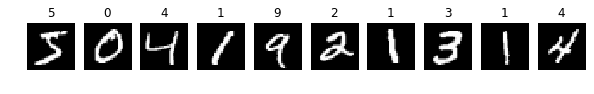

In [4]:
fig, ax = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    ax[i].imshow(training_data[i], cmap="gray")
    ax[i].set_title(training_labels[i])
    ax[i].axis("off")

In [5]:
tf.reset_default_graph()
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))
training_batch_size = 128
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)
training_dataset = training_dataset.shuffle(256)

In [6]:
iterator = tf.data.Iterator.from_structure(training_dataset.output_types, training_dataset.output_shapes)
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)
next_batch = iterator.get_next()

In [7]:
input_data = tf.cast(tf.reshape(next_batch[0], [-1, 784]), tf.float32)
labels = tf.cast(next_batch[1], tf.int64)
labels_one_hot = tf.one_hot(next_batch[1], 10)

In [8]:
weights = tf.Variable(tf.random_normal([784, 10], stddev=2e-06))
biases =  tf.Variable(tf.zeros(10))
logits = input_data @ weights + biases
output = tf.nn.softmax(logits)

In [9]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels_one_hot, logits=logits))
accuracy = tf.equal(tf.argmax(output, axis=1), labels)
accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))

In [10]:
learning_rate = 1e-5
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_step = optimizer.minimize(loss)

In [11]:
tf.summary.scalar("Loss", loss)
tf.summary.scalar("Accuracy", accuracy)
merged_summaries = tf.summary.merge_all()

training_writer = tf.summary.FileWriter("summaries/training/")
validation_writer = tf.summary.FileWriter("summaries/validation/", flush_secs=2)

In [12]:
epochs = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    global_step = 0
    for _ in range(epochs):
        sess.run(training_init_op)
        while True:
            try:
                _, summary = sess.run((training_step, merged_summaries))
                training_writer.add_summary(summary, global_step)
                global_step += 1
            except tf.errors.OutOfRangeError:
                break
        
        sess.run(validation_init_op)
        summary = sess.run(merged_summaries)
        validation_writer.add_summary(summary, global_step)